# PPAC Analysis Notebook

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## Load Data

In [2]:
data_dir = 'correlations/long_run_4mbar_500V'
data_paths = {
    "coincident": Path(f"{data_dir}/coincident_imp.pkl"),
    "decay_candidates": Path(f"{data_dir}/decay_candidates.pkl"),
    "final_correlated": Path(f"{data_dir}/final_correlated.pkl"),
}
data = {}
for name, path in data_paths.items():
    if path.exists():
        data[name] = pd.read_pickle(path)
        print(f"Loaded {name}: {len(data[name])} rows")
    else:
        print(f"File {path} not found")

Loaded coincident: 454177 rows
Loaded decay_candidates: 66889 rows
Loaded final_correlated: 6563 rows


## Basic Inspection

In [3]:
for name, df in data.items():
    display(df.head())

,imp_timetag,imp_x,imp_y,imp_tagx,imp_tagy,imp_nfile,imp_tdelta,imp_nX,imp_nY,imp_xE,...,dt_anodeH_ps,dt_cathode_ns,dt_anodeV_ns,dt_anodeH_ns,dt_cathode_us,dt_anodeV_us,dt_anodeH_us,dt_anodeH_us_corr,dt_anodeV_us_corr,dt_cathode_us_corr
0,198634810650,9,50,198634810650,198634760742,0,49908.0,1,1,6782.193848,...,-1430192.0,-1423.496,-1431.597,-1430.192,-1.423496,-1.431597,-1.430192,-1.430192,-1.431597,-1.423496
1,529691550542,147,12,529691550542,529691391264,0,159278.0,1,1,38852.691406,...,-1507289.0,-1502.885,-1508.120,-1507.289,-1.502885,-1.508120,-1.507289,-1.507289,-1.508120,-1.502885
2,912400550245,18,11,912400550245,912400538374,0,11871.0,1,1,2687.152832,...,-1424942.0,-1417.065,-1422.994,-1424.942,-1.417065,-1.422994,-1.424942,-1.424942,-1.422994,-1.417065
3,916484660872,40,19,916484660872,916484657870,0,3002.0,1,1,2320.956543,...,-1427958.0,-1421.015,-1425.733,-1427.958,-1.421015,-1.425733,-1.427958,-1.427958,-1.425733,-1.421015
4,974031403169,29,3,974031403169,974031360827,0,42342.0,1,1,13223.660156,...,-1421801.0,-1416.924,-1424.154,-1421.801,-1.416924,-1.424154,-1.421801,-1.421801,-1.424154,-1.416924


,t,x,y,tagx,tagy,nfile,xboard,yboard,tdelta,nX,nY,xE,yE,event_type,recoil_index,recoil_time_sec,ppac_flag,is_clean,log_dt
0,2.839951,147,12,2839951104007,2839951009995,0,0,7,94012.0,1,1,333.187103,416.077087,imp,1,0.529692,both,False,0.837360
1,20.860982,29,3,20860982345999,20860982277992,0,4,6,68007.0,1,1,328.327667,386.433502,imp,4,0.974031,both,False,2.990064
2,6.790124,37,22,6790123589371,6790123537373,0,4,7,51998.0,1,1,2623.933105,2641.425293,imp,6,1.142596,both,False,1.731218
3,1.718427,137,45,1718426961995,1718426873998,0,0,6,87997.0,1,1,340.905670,338.431091,imp,10,1.445411,both,False,-1.298225
4,13.175558,152,33,13175557948998,13175557849998,0,1,6,99000.0,1,1,400.480774,385.106293,imp,13,1.527234,both,False,2.455162


,recoil_x,recoil_y,recoil_xE,timetag,cathode_timetag,cathode_energy,anodeV_timetag,anodeV_energy,anodeH_timetag,anodeH_energy,...,alpha_y,alpha_t,alpha_xE,alpha_dt,chain,electron_x,electron_y,electron_t,electron_xE,electron_dt
0,35.0,15.0,6862.952148,6.046224e+13,6.046224e+13,4042.0,6.046224e+13,920.0,6.046224e+13,1389.0,...,15.0,63.474081,8204.387695,3.011841,RA,NaN,NaN,NaN,NaN,NaN
1,87.0,26.0,4388.934570,9.344928e+13,9.344928e+13,3863.0,9.344928e+13,1198.0,9.344928e+13,1062.0,...,26.0,97.735318,8256.998047,4.286037,RA,NaN,NaN,NaN,NaN,NaN
2,15.0,9.0,6385.057129,9.992233e+13,9.992233e+13,3248.0,9.992233e+13,773.0,9.992233e+13,1004.0,...,9.0,101.742032,8157.464844,1.819700,RA,NaN,NaN,NaN,NaN,NaN
3,68.0,10.0,5916.498047,1.458216e+14,1.458216e+14,3145.0,1.458216e+14,1277.0,1.458216e+14,526.0,...,10.0,146.771431,8253.756836,0.949802,RA,NaN,NaN,NaN,NaN,NaN
4,68.0,9.0,5916.498047,1.458216e+14,1.458216e+14,3145.0,1.458216e+14,1277.0,1.458216e+14,526.0,...,9.0,146.771431,8253.756836,0.949802,RA,NaN,NaN,NaN,NaN,NaN


## REA
Plot a histogram of recoil energies from the coincident events.

,recoil_x,recoil_y,recoil_xE,timetag,cathode_timetag,cathode_energy,anodeV_timetag,anodeV_energy,anodeH_timetag,anodeH_energy,...,alpha_y,alpha_t,alpha_xE,alpha_dt,chain,electron_x,electron_y,electron_t,electron_xE,electron_dt
1016,112.0,47.0,5849.625488,4.851960e+15,4.851960e+15,4062.0,4.851960e+15,1762.0,4.851960e+15,620.0,...,47.0,4855.255781,8273.665039,1.809274,REA,112.0,47.0,4853.446507,254.604874,1.486293
1017,27.0,22.0,7219.605469,7.226757e+15,7.226757e+15,2791.0,7.226757e+15,974.0,7.226757e+15,548.0,...,22.0,7231.031212,8220.322266,0.592706,REA,27.0,22.0,7230.438506,628.742920,3.681808
1018,114.0,3.0,6206.458008,9.903470e+15,9.903470e+15,3377.0,9.903470e+15,701.0,9.903470e+15,1416.0,...,3.0,9906.916746,8177.235840,1.683810,REA,114.0,3.0,9905.232937,327.864685,1.763097
2264,50.0,48.0,5490.928711,1.545785e+15,1.545785e+15,4951.0,1.545785e+15,789.0,1.545785e+15,2627.0,...,48.0,1549.641867,8205.927734,1.731084,REA,50.0,48.0,1547.910783,603.144104,2.125668
2265,66.0,50.0,6865.623047,2.056732e+15,2.056732e+15,3565.0,2.056732e+15,891.0,2.056732e+15,1243.0,...,50.0,2060.357126,8262.849609,3.352916,REA,66.0,50.0,2057.004210,382.812195,0.272561
2266,95.0,48.0,6631.552246,2.168259e+15,2.168259e+15,4321.0,2.168259e+15,1134.0,2.168259e+15,1425.0,...,48.0,2171.307092,8262.400391,0.928668,REA,95.0,48.0,2170.378424,379.965820,2.119685
2267,131.0,35.0,4857.732910,5.162223e+15,5.162223e+15,2860.0,5.162223e+15,861.0,5.162223e+15,550.0,...,35.0,5167.089910,8282.479492,0.912240,REA,131.0,35.0,5166.177670,407.361664,3.954928
2268,53.0,15.0,7033.510742,5.363413e+15,5.363413e+15,3001.0,5.363413e+15,893.0,5.363413e+15,728.0,...,15.0,5367.426728,8273.238281,3.602669,REA,53.0,15.0,5363.824058,290.991974,0.410828
2269,21.0,49.0,6083.557617,7.795087e+15,7.795087e+15,4002.0,7.795087e+15,1400.0,7.795087e+15,876.0,...,49.0,7796.093374,8191.303711,0.788305,REA,21.0,49.0,7795.305069,455.072327,0.218036
2270,79.0,19.0,4307.506836,7.870899e+15,7.870899e+15,2026.0,7.870899e+15,639.0,7.870899e+15,319.0,...,19.0,7871.520464,8218.794922,0.433524,REA,79.0,19.0,7871.086940,604.265625,0.188303


26


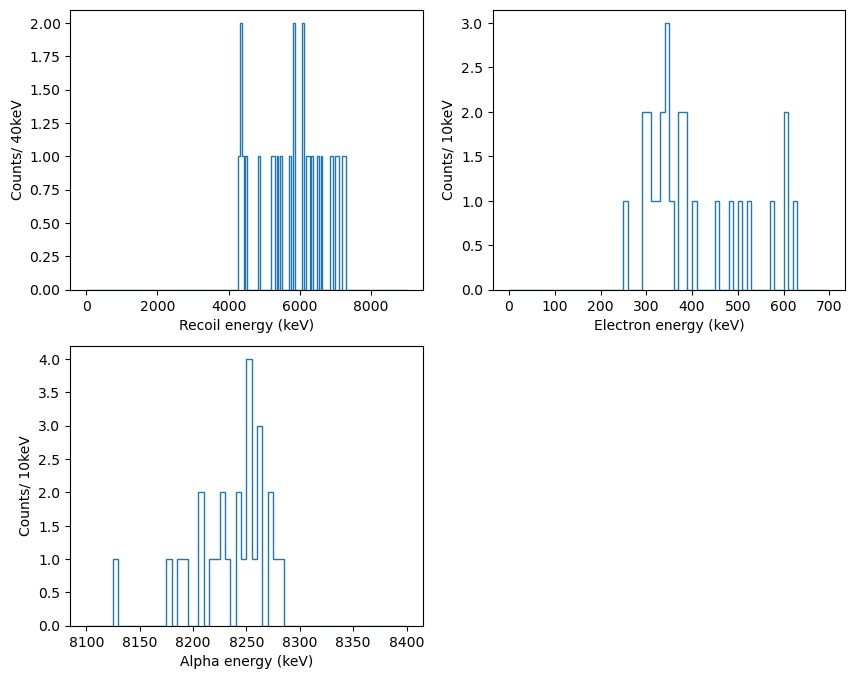

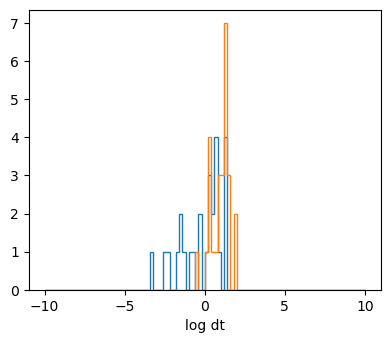

In [4]:
# Inspect
df = data["final_correlated"]
df_REA = df[df["chain"] == "REA"]
display(df_REA)
print(len(df_REA))

# plotting
# Plotting

if len(df_REA) >0:
    
    # Energies
    plt.figure(figsize=(10,8))
    plt.subplot(221)
    plt.hist(df_REA['recoil_xE'], histtype='step',bins=175, range=(0,9000))
    plt.xlabel('Recoil energy (keV)')
    plt.ylabel(r'Counts/ 40keV')
    plt.subplot(222)
    plt.hist(df_REA['electron_xE'], histtype='step',bins=70, range=(0,700))
    plt.xlabel('Electron energy (keV)')
    plt.ylabel(r'Counts/ 10keV')
    plt.subplot(223)
    plt.hist(df_REA['alpha_xE'], histtype='step', bins=60, range=(8100,8400))
    plt.xlabel('Alpha energy (keV)')
    plt.ylabel(r'Counts/ 10keV')
    plt.show()
    plt.close()
    
    # KHS plots 
    plt.figure(figsize=(10,8))
    plt.subplot(221)
    plt.hist(np.log(np.abs(df_REA['electron_t']-df_REA[r'recoil_t'])), histtype='step', bins =100, range=(-10,10))
    plt.xlabel('log dt')
    plt.subplot(221)
    plt.hist(np.log(np.abs(df_REA['alpha_t']-df_REA[r'recoil_t'])), histtype='step', bins =100, range=(-10,10))

# RE

,recoil_x,recoil_y,recoil_xE,timetag,cathode_timetag,cathode_energy,anodeV_timetag,anodeV_energy,anodeH_timetag,anodeH_energy,...,alpha_y,alpha_t,alpha_xE,alpha_dt,chain,electron_x,electron_y,electron_t,electron_xE,electron_dt
343,32.0,53.0,5826.856445,3.027000e+12,3.026999e+12,4402.0,3.026999e+12,1148.0,3.026999e+12,1683.0,...,NaN,NaN,NaN,NaN,RE,32.0,53.0,4.838240,456.328278,1.811239
344,5.0,32.0,3087.247803,3.036897e+13,NaN,NaN,3.036897e+13,1290.0,NaN,NaN,...,NaN,NaN,NaN,NaN,RE,5.0,32.0,32.394117,327.800018,2.025149
345,11.0,25.0,4345.555664,4.293780e+13,4.293780e+13,2893.0,4.293780e+13,907.0,4.293780e+13,709.0,...,NaN,NaN,NaN,NaN,RE,11.0,25.0,43.924060,509.032776,0.986255
346,99.0,33.0,6443.124512,5.465092e+13,5.465092e+13,3887.0,5.465092e+13,748.0,5.465092e+13,1447.0,...,NaN,NaN,NaN,NaN,RE,99.0,33.0,55.793876,656.751709,1.142959
347,58.0,42.0,6504.312500,6.669078e+13,6.669077e+13,3447.0,6.669077e+13,1259.0,6.669077e+13,763.0,...,NaN,NaN,NaN,NaN,RE,58.0,42.0,67.434616,648.772583,0.743841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6556,1.0,31.0,3222.599854,4.029796e+15,4.029796e+15,2918.0,4.029796e+15,671.0,4.029796e+15,877.0,...,NaN,NaN,NaN,NaN,RE,1.0,31.0,4033.084217,522.554871,3.288695
6557,52.0,46.0,4130.085938,4.031509e+15,NaN,NaN,4.031509e+15,12.0,NaN,NaN,...,NaN,NaN,NaN,NaN,RE,52.0,46.0,4035.008008,296.391357,3.499110
6558,3.0,57.0,3329.875488,4.051589e+15,4.051589e+15,1934.0,4.051589e+15,416.0,4.051589e+15,423.0,...,NaN,NaN,NaN,NaN,RE,3.0,57.0,4052.636623,332.513367,1.047817
6559,25.0,51.0,4918.733887,4.062617e+15,4.062617e+15,4264.0,4.062617e+15,1020.0,4.062617e+15,1536.0,...,NaN,NaN,NaN,NaN,RE,25.0,51.0,4063.017848,421.568665,0.401089


4449


Text(0, 0.5, 'Counts/ 10keV')

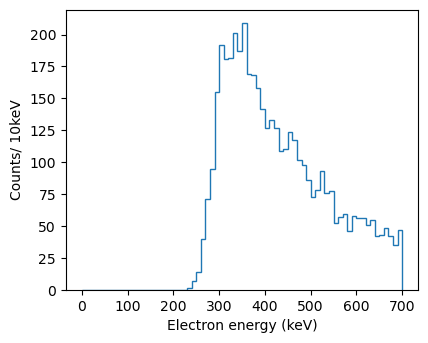

In [7]:
df = data["final_correlated"]
df_RE = df[df["chain"] == "RE"]
display(df_RE)
print(len(df_RE))
plt.figure(figsize=(10,8))
plt.subplot(221)
plt.hist(df_RE['electron_xE'], histtype='step',bins=70, range=(0,700))
plt.xlabel('Electron energy (keV)')
plt.ylabel(r'Counts/ 10keV')

# RA

,recoil_x,recoil_y,recoil_xE,timetag,cathode_timetag,cathode_energy,anodeV_timetag,anodeV_energy,anodeH_timetag,anodeH_energy,...,alpha_y,alpha_t,alpha_xE,alpha_dt,chain,electron_x,electron_y,electron_t,electron_xE,electron_dt
0,35.0,15.0,6862.952148,6.046224e+13,6.046224e+13,4042.0,6.046224e+13,920.0,6.046224e+13,1389.0,...,15.0,63.474081,8204.387695,3.011841,RA,NaN,NaN,NaN,NaN,NaN
1,87.0,26.0,4388.934570,9.344928e+13,9.344928e+13,3863.0,9.344928e+13,1198.0,9.344928e+13,1062.0,...,26.0,97.735318,8256.998047,4.286037,RA,NaN,NaN,NaN,NaN,NaN
2,15.0,9.0,6385.057129,9.992233e+13,9.992233e+13,3248.0,9.992233e+13,773.0,9.992233e+13,1004.0,...,9.0,101.742032,8157.464844,1.819700,RA,NaN,NaN,NaN,NaN,NaN
3,68.0,10.0,5916.498047,1.458216e+14,1.458216e+14,3145.0,1.458216e+14,1277.0,1.458216e+14,526.0,...,10.0,146.771431,8253.756836,0.949802,RA,NaN,NaN,NaN,NaN,NaN
4,68.0,9.0,5916.498047,1.458216e+14,1.458216e+14,3145.0,1.458216e+14,1277.0,1.458216e+14,526.0,...,9.0,146.771431,8253.756836,0.949802,RA,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6235,42.0,42.0,6123.369141,3.898232e+15,3.898232e+15,4378.0,3.898232e+15,1031.0,3.898232e+15,1531.0,...,42.0,3899.831587,8207.346680,1.599681,RA,NaN,NaN,NaN,NaN,NaN
6236,53.0,32.0,5849.770508,3.987799e+15,3.987799e+15,3589.0,3.987799e+15,978.0,3.987799e+15,1089.0,...,32.0,3988.321564,8263.240234,0.522900,RA,NaN,NaN,NaN,NaN,NaN
6237,91.0,36.0,4410.116211,4.006107e+15,4.006107e+15,3930.0,4.006107e+15,1002.0,4.006107e+15,1381.0,...,36.0,4013.553957,8247.821289,7.446517,RA,NaN,NaN,NaN,NaN,NaN
6238,53.0,24.0,6371.656250,4.015510e+15,4.015510e+15,3561.0,4.015510e+15,1319.0,4.015510e+15,727.0,...,24.0,4018.879322,8263.240234,3.369212,RA,NaN,NaN,NaN,NaN,NaN


2088


Text(0, 0.5, 'Counts/ 40keV')

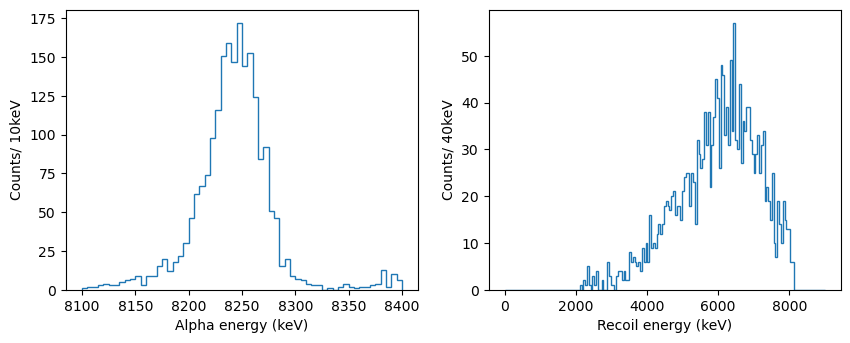

In [6]:
df = data["final_correlated"]
df_RA = df[df["chain"] == "RA"]
display(df_RA)
print(len(df_RA))
plt.figure(figsize=(10,8))
plt.subplot(221)
plt.hist(df_RA['alpha_xE'], histtype='step', bins=60, range=(8100,8400))
plt.xlabel('Alpha energy (keV)')
plt.ylabel(r'Counts/ 10keV')

plt.subplot(222)
plt.hist(df_RA['recoil_xE'], histtype='step',bins=175, range=(0,9000))
plt.xlabel('Recoil energy (keV)')
plt.ylabel(r'Counts/ 40keV')